## Transformer 结构 ##

**Encoder**: \
Input pre-processing -> Encoders \
Input Embedding (token, position) -> MHA -> Add & LN -> FFN -> Add & LN -> ... -> Encoder Output

**Decoder**: \
Output pre-processing -> Decoder (masked mha -> cross mha) ->  Output post-proccessing \
Output (Target output) Embedding -> Masked MHA -> Add & LN -> Cross MHA (Encoder KV) -> Add & LN -> FFN -> Add & LN -> ... -> Decoder Output -> FC & SoftMax -> Propability Distribution

**Training in Decoder**: \
Teacher Forcing: 提供 Target Output 可以使训练过程更加稳定和高效 (可能导致模型在推理阶段表现不佳), **Scheduled Sampling** 和 **Beam Search** 等方法改善这一问题 \
Masking: 训练时用于遮掩 Target Output 中还没有出现的词 \

Eg. Franch into English \
Input Franch words -> Encoder -> Franch words vector ----------**K,V**-----------↓\
Target English wrods -> Masked Attention -> English words vector -> **Cross Attention** -> English words (words) -> Output

**Main Features**: \
Positional Encoding (seqlen * embedding/hidden dim) \
Input/Output Embedding (bs * seqlen -> bs * seqlen * embedding/hidden dim) \
Multi-Head Attention (embedding/hidden dim = nhead * dhead) \
Residual Connection \
Layer Normalization \
Masked Attention (Hiding unseen words during training 避免模型作弊, 一般为左下三角矩阵, 1st row: 1 0 0 0 0, 2nd row: 1 1 0 0 0..., 每一步都只能看到当前和以前的位置) \
Cross Attention (K,V from Encoder Output) \
**Auto-regressive generation** (以 "start" 起始结合用户的 prompt 输入给 Decoder, "start" + "prompt" -> 1st Decoder -> out1, start + "prompt" + out1 -> 2nd Decoder -> out2, ...  + "end" -> end) \
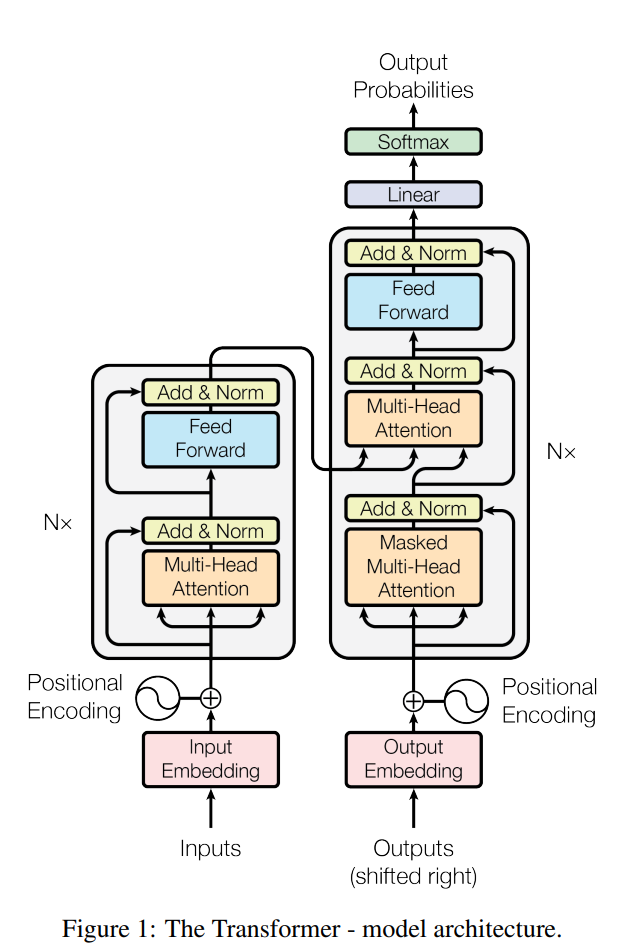

## Self-Attention
$$\begin{aligned}
Attention(Q,K,V) & = softmax\left(\frac{{QK^T}}{{\sqrt{{d_K}}}}\right)V
\\
Q,K,V(bs, seq, d_k) & => AttWeight(bs, seq, seq) => AttRes(bs, seq, d_k)
\end{aligned}$$

In [ ]:
import math
import torch
import torch.nn as nn

class SelfAttentionV1(nn.Module):
    def __init__(self, hidden_dim: int=728):
        super().__init__()
        self.hidden_dim = hidden_dim

        self.query_proj = nn.Linear(hidden_dim, hidden_dim)
        self.key_proj = nn.Linear(hidden_dim, hidden_dim)
        self.value_proj = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # X.shape = (batch_size, seq_len, hidden_dim)
        Q = self.query_proj(x)
        K = self.key_proj(x)
        V = self.value_proj(x)
        # Q, K, V.shape = (batch_size, seq_len, hidden_dim)

        att_scores = torch.matmul(Q, K.transpose(-1, -2))
        att_probs = torch.softmax(att_scores / math.sqrt(self.hidden_dim), dim=-1)
        # att_scores, weight.shape = (batch_size, seq_len, seq_len)

        att_output = torch.matmul(att_probs, V)
        # output.shape = (batch_size, seq_len, hidden_dim)
        print(att_output)
        return att_output

X = torch.rand(3, 2, 4)
att_net = SelfAttentionV1(4)
att_net(X)

tensor([[[0.4933, 0.5067],
         [0.4946, 0.5054]],

        [[0.4784, 0.5216],
         [0.4656, 0.5344]],

        [[0.5072, 0.4928],
         [0.5121, 0.4879]]], grad_fn=<SoftmaxBackward0>)


tensor([[[0.5334, 0.3425, 0.1624, 0.4053],
         [0.5331, 0.3425, 0.1620, 0.4050]],

        [[0.8371, 0.4340, 0.5380, 0.6400],
         [0.8379, 0.4315, 0.5399, 0.6386]],

        [[0.7707, 0.3092, 0.4332, 0.3983],
         [0.7721, 0.3113, 0.4359, 0.3998]]], grad_fn=<UnsafeViewBackward0>)

### Efficient computation (QKV) ###

将 QKV 封在一个矩阵里，计算 attention score 时再分开

In [ ]:
class SelfAttentionV2(nn.Module):
    def __init__(self, hidden_dim: int=728):
        super().__init__()
        self.hidden_dim = hidden_dim

        self.proj = nn.Linear(hidden_dim, hidden_dim*3)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # X.shape = (batch_size, seq_len, hidden_dim)
        QKV = self.proj(x)
        # QKV.shape = (batch_size, seq_len, hidden_dim*3)
        Q, K, V = torch.split(QKV, self.hidden_dim, dim=-1)
        # Q, K, V.shape = (batch_size, seq_len, hidden_dim)

        att_probs = torch.softmax(
            Q @ K.transpose(-1, -2) / math.sqrt(self.hidden_dim), 
            dim=-1
        )
        # att_value, weight.shape = (batch_size, seq_len, seq_len)

        att_output = att_probs @ V
        # output.shape = (batch_size, seq_len, hidden_dim)
        print(att_output)

        return att_output

X = torch.rand(3, 2, 4)
att_net = SelfAttentionV2(4)
att_net(X)
        

tensor([[[0.4598, 0.5402],
         [0.4736, 0.5264]],

        [[0.4986, 0.5014],
         [0.4991, 0.5009]],

        [[0.5293, 0.4707],
         [0.5386, 0.4614]]], grad_fn=<SoftmaxBackward0>)


tensor([[[-0.5553,  0.0591,  0.7540,  0.0332],
         [-0.5550,  0.0663,  0.7580,  0.0386]],

        [[-0.6358,  0.0309,  0.7345, -0.0729],
         [-0.6357,  0.0310,  0.7345, -0.0729]],

        [[-0.4657,  0.1483,  0.8361,  0.2837],
         [-0.4619,  0.1448,  0.8327,  0.2829]]], grad_fn=<UnsafeViewBackward0>)

## Dropout, Attention Mask, Output Projection ##

dropout 的作用：防止过拟合；训练时随机将一部分神经元输出置0，推理时按照训练时 dropout 比例缩放神经元的输出

attention mask 的作用：防止计算无效的 attention score；用 mask 屏蔽某些不相关或无效的位置

output projection 的作用：将输出映射回原始维度，增加模型灵活性；让模型可以拥有更多可学习参数，间接防止 Attention Score 过大时造成的梯度爆炸或不稳定训练（其实已经由 dk scale 缓解过了）

In [4]:
import os
os.environ['HF_HOME'] = "E:\Production\models\hgf" # redirect hf cache
os.environ['HF_ENDPOINT'] = "https://hf-mirror.com"
os.environ['HF_HUB_DISABLE_SYMLINKS_WARNING'] = '1' # disable hf symlink warning

In [ ]:
# dropout -> attention weight
# attention mask -> attention weight
# output projection
import torch
import math
import torch.nn as nn


class SelfAttentionV3(nn.Module):
    def __init__(self, hidden_dim: int=728, dropout_prob: float=0.1):
        super().__init__()
        self.hidden_dim = hidden_dim

        self.proj = nn.Linear(hidden_dim, hidden_dim*3)
        self.att_dp = nn.Dropout(dropout_prob)
        self.output_proj = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, x: torch.Tensor, att_mask=None) -> torch.Tensor:
        # (batch_size, seq_len, hidden_dim)
        QKV = self.proj(x)
        Q, K, V = torch.split(QKV, self.hidden_dim, dim=-1)

        # (bs, seq, hid) @ (bs, hid, seq) => (bs, seq, seq)
        att_scores = Q @ K.transpose(-1, -2) / math.sqrt(self.hidden_dim)
        if att_mask is not None:
            att_scores = att_scores.masked_fill(att_mask == 0, float("-inf"))
            # mask with a very small value
        att_probs = torch.softmax(att_probs, dim=-1)
        att_probs = self.att_dp(att_probs)

        att_output = att_probs @ V
        # (batch_size, seq_len, hidden_dim)
        output = self.output_proj(att_output)
        print(output)

        return output

X = torch.rand(3, 4, 2)

# needed mask: (batch_size, seq_len, seq_len)
mask = torch.tensor(
    [
        [1, 1, 1, 0], # attention on the first 3 seqs
        [1, 1, 0, 0], # attention on the first 2 seqs
        [1, 0, 0, 0]  # attention on the first 1 seq
    ]
)
# broadcast -> 3, 4, 4
mask = mask.unsqueeze(dim=1).repeat(1, 4, 1)
att_net = SelfAttentionV3(2)
att_net(X, mask)

tensor([[[0.3825, 0.3869, 0.3418, 0.0000],
         [0.0000, 0.3862, 0.3429, 0.0000],
         [0.3855, 0.3906, 0.3350, 0.0000],
         [0.3843, 0.3896, 0.3373, 0.0000]],

        [[0.5423, 0.5688, 0.0000, 0.0000],
         [0.0000, 0.5684, 0.0000, 0.0000],
         [0.5469, 0.5642, 0.0000, 0.0000],
         [0.5456, 0.5655, 0.0000, 0.0000]],

        [[1.1111, 0.0000, 0.0000, 0.0000],
         [1.1111, 0.0000, 0.0000, 0.0000],
         [1.1111, 0.0000, 0.0000, 0.0000],
         [1.1111, 0.0000, 0.0000, 0.0000]]], grad_fn=<MulBackward0>)


tensor([[[-0.4466, -0.1273],
         [-0.3709, -0.1477],
         [-0.4478, -0.1267],
         [-0.4474, -0.1269]],

        [[-0.3728, -0.1788],
         [-0.3144, -0.1832],
         [-0.3729, -0.1786],
         [-0.3729, -0.1786]],

        [[-0.3067, -0.2082],
         [-0.3067, -0.2082],
         [-0.3067, -0.2082],
         [-0.3067, -0.2082]]], grad_fn=<ViewBackward0>)

## Multi-Head Attention ##
Transformer 结构中使用的 Attention

通过将输入向量切分为多个子空间（比如 h 个 head）并行计算，让模型在计算 Attention 时可以同时关注到不同子空间的信息，从而提升模型的表达能力。

$$\begin{aligned}
MultiHead(Q,K,V) & = Concat\left(head_1,...,head_h\right)W
\\
hidden\_dim & = d_k, \quad{nums\_head} = h, \quad{head\_dim = d_k/h}
\\
head_i & = Attention\left(QW_i^Q, KW_i^K, VW_i^V\right) = SoftMax\left(\frac{Q_iK_i^T}{\sqrt{d_k/h}}\right)V_i
\end{aligned}$$


### MH Attention Score ###
$$\begin{aligned}
QKV(bs, seq, d_k)\quad{}& =>\quad{}Q_iK_iVi(bs, seq, h, d_k/h)\quad{}=>\quad{}Q_iK_iVi(bs, h, seq, d_k/h)
\\
Q_i(bs, h, seq, d_k/h) @ K_i^T\quad{}& =>\quad{}AttWeight(bs, h, seq, seq)\quad{}=>\quad{}AttRes(bs, h, seq, d_k/h)
\\
AttRes(bs, h, seq, d_k/h)\quad{}& =>\quad{}Output(bs, seq, d_k)
\end{aligned}$$

In [ ]:
import math
import torch
import torch.nn as nn

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, hidden_dim, nums_head, dropout_prob=0.1, eps=1e-7):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.nums_head = nums_head
        self.head_dim = hidden_dim // nums_head # nums_head * head_dim = hidden_dim

        self.proj = nn.Linear(hidden_dim, hidden_dim*3) # (QKV:hidden_dim*3 -> Q:hidden_dim = head_dim * head_nnum)
        self.att_dp = nn.Dropout(dropout_prob)
        self.output_proj = nn.Linear(hidden_dim, hidden_dim)
        self.mha_ln = nn.LayerNorm(hidden_dim, eps)

    def forward(self, x, att_mask=None):
        # (bs, seq, hid)
        bs, seq, _ = x.size()
        QKV = self.proj(x)
        Q, K, V = torch.split(QKV, self.hidden_dim, dim=-1)

        # view hid -> nums_head, head_dim
        # attention on seq -> transpose seq and nums_head -> (bs, nums_head, seq, head_dim)
        Q_state = Q.view(bs, seq, self.nums_head, self.head_dim).transpose(1, 2)
        K_state = K.view(bs, seq, self.nums_head, self.head_dim).transpose(1, 2)
        V_state = V.view(bs, seq, self.nums_head, self.head_dim).transpose(1, 2)

        att_scores = Q_state @ K_state.transpose(-1, -2) / math.sqrt(self.head_dim)
        if att_mask is not None:
            att_mask = att_mask.tril() # 只取下三角矩阵
            att_scores = att_scores.masked_fill(att_mask == 0, float("-inf"))
        else:
            att_mask = torch.ones_like(att_scores).tril() # 同 shape 下三角矩阵
            att_scores = att_scores.masked_fill(att_mask == 0, float("-inf"))
        # (bs, nums_head, seq, seq)
        
        att_probs = torch.softmax(att_scores, dim=-1)
        att_probs = self.att_dp(att_probs)
        att_res = att_probs @ V_state
        # (bs nums_head, seq, head_dim)

        # shape recovery and memory contiguous
        output_mid = att_res.transpose(1, 2).contiguous().view(bs, seq, self.hidden_dim)
        output = self.output_proj(output_mid)
        # (bs, seq, hid)

        output = self.mha_ln(output + x) # residue

        return output



X = torch.rand(3, 4, 128)

# needed mask: (batch_size, seq_len, seq_len)
att_net = MultiHeadSelfAttention(128,8)
att_net(X)


tensor([[[-0.6974, -1.1297, -0.2815,  ...,  0.1229, -1.7440, -0.9814],
         [-1.6842, -0.5094,  0.5788,  ...,  2.0587,  0.3376, -1.1407],
         [-0.8705,  0.0910,  0.0521,  ..., -0.3106, -0.7151,  0.7737],
         [-1.2727,  1.6797,  0.0039,  ..., -0.6457,  1.5550,  1.1087]],

        [[ 0.0996, -0.1432, -0.3044,  ...,  0.5436,  0.2069, -0.4871],
         [-1.4028, -1.2467,  1.2121,  ...,  1.8855,  0.8231, -0.0427],
         [-1.3889,  0.1612,  1.3702,  ..., -0.8734,  0.7603,  0.5401],
         [-0.0547,  1.4796, -1.3809,  ..., -0.3491,  0.3311,  0.8668]],

        [[-0.9353, -0.7861, -1.0340,  ...,  0.6125,  0.0548,  0.0595],
         [-1.0326, -1.0184,  0.1182,  ..., -0.8403, -1.3869,  0.9898],
         [-1.7712,  0.7629,  1.0023,  ...,  1.6320,  0.0498, -0.4921],
         [-0.9796, -0.4384, -0.7357,  ...,  0.9385,  0.6114,  1.0510]]],
       grad_fn=<NativeLayerNormBackward0>)

Dictation

In [ ]:
class MHA(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout_prob=0.1, eps=1e-7):
        super().__init__()
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.proj = nn.Linear(hid_dim, hid_dim * 3)

        self.att_dp = nn.Dropout(dropout_prob)
        self.o_proj = nn.Linear(hid_dim, hid_dim)
        self.mha_ln = nn.LayerNorm(hid_dim, eps)

    def forward(self, x, att_mask=None):
        bs, seq, _ = x.size() # [bs, seq, hid_dim]
        Q, K, V = torch.split(self.proj(x), self.hid_dim, dim=-1) # [bs, seq, hid_dim]

        # [bs, n_heads, seq, head_dim]
        Q_state = Q.view(bs, seq, self.n_heads, self.head_dim).transpose(1, 2)
        K_state = K.view(bs, seq, self.n_heads, self.head_dim).transpose(1, 2)
        V_state = V.view(bs, seq, self.n_heads, self.head_dim).transpose(1, 2)

        att_scores = Q_state @ K_state.transpose(-1, -2) / math.sqrt(self.head_dim) # [bs, n_heads, seq, seq]
        if att_mask:
            att_scores = att_scores.masked_fill(att_mask == 0, float("-inf"))
        else:
            att_mask = torch.ones_like(att_scores).tril()
            att_scores = att_scores.masked_fill(att_mask == 0, float("-inf"))
        att_probs = torch.softmax(att_scores, dim=-1)
        att_probs = self.att_dp(att_probs)
        att_output = att_probs @ V_state # [bs, n_heads, seq, head_dim]
        output = self.o_proj(att_output.transpose(1, 2).contiguous().view(bs, seq, -1)) # [bs, seq, hid_dim]

        # residue connection
        output = self.mha_ln(output + x) # [bs, seq, hid_dim]

        return output
    

X = torch.rand(3, 4, 128)

mha_layer = MHA(hid_dim=128, n_heads=8)
mha_layer(X)


## Causal-LM Decoder ##
$$
\text{Transformer Decoder} (\text{Causal LM: Self MHA + FFN} \left( \text{Residue + Norm}\right))
$$

In [ ]:
import torch
import math
import torch.nn as nn

class SimpleDecoderLayer(nn.Module):
    def __init__(self, hidden_dim: int, nums_head: int, att_dp_r=0.1):
        super().__init__()
        assert  hidden_dim % nums_head == 0
        self.nums_head = nums_head
        self.hidden_dim = hidden_dim
        self.head_dim = hidden_dim // nums_head

        # MHA, FFN
        # MHA - Attention Mechanism, applying dropout, layernorm and attention mask
        self.q_proj = nn.Linear(hidden_dim, hidden_dim)
        self.k_proj = nn.Linear(hidden_dim, hidden_dim)
        self.v_proj = nn.Linear(hidden_dim, hidden_dim)
        self.o_proj = nn.Linear(hidden_dim, hidden_dim)
        self.att_dp = nn.Dropout(att_dp_r)
        self.att_norm = nn.LayerNorm(hidden_dim, eps=0.0000001)

        # FFN - 2 Linear, 1 Act, applying dropout and layernorm
        self.up_proj = nn.Linear(hidden_dim, hidden_dim * 4)
        self.down_proj = nn.Linear(hidden_dim * 4, hidden_dim)
        self.act_fn = nn.GELU()
        self.ffn_dp = nn.Dropout(0.1)
        self.ffn_ln = nn.LayerNorm(hidden_dim, eps=0.0000001)

    def att_layer(self, Q, K, V, bs, seq, att_mask=None):
        att_scores = Q @ K.transpose(-1, -2) / math.sqrt(self.head_dim) # bs, nums_head, seq, seq
        if att_mask is not None:
            att_mask = att_mask.tril()
            att_scores = att_scores.masked_fill(att_mask == 0, float("-inf"))
        else:
            att_mask = torch.ones_like(att_scores).tril()
            att_scores = att_scores.masked_fill(att_mask == 0, float("-inf"))
        # (bs, nums_head, seq, seq)
        
        att_probs = torch.softmax(att_scores, dim=-1)
        att_probs = self.att_dp(att_probs)
        att_output = att_probs @ V # SoftMax(QK^T / sqrt(d_k))V
        # (bs nums_head, seq, head_dim)

        # shape recovery and memory contiguous
        output_mid = att_output.transpose(1, 2).contiguous().view(bs, seq, -1)
        output = self.o_proj(output_mid)
        # (bs, seq, hid)

        return output

    def mha(self, X, att_mask=None):
        bs, seq, _ = X.size()
        Q = self.q_proj(X).view(bs, seq, self.nums_head, -1).transpose(1, 2)
        K = self.k_proj(X).view(bs, seq, self.nums_head, -1).transpose(1, 2)
        V = self.v_proj(X).view(bs, seq, self.nums_head, -1).transpose(1, 2)

        output = self.att_layer(Q, K, V, bs, seq, att_mask)

        return self.att_norm(X + output)
    
    def ffn(self, X):
        up = self.up_proj(X)
        up = self.act_fn(up)
        down = self.down_proj(up)
        down = self.ffn_dp(down)
        return self.ffn_ln(X + down)

    def forward(self, X, att_mask=None) -> torch.Tensor:
        X = self.mha(X, att_mask)
        X = self.ffn(X)
        return X


class Decoder(nn.Module):
    def __init__(self, hidden_dim: int, nums_head: int, dropout_rate=0.1, layer_nums=5):
        super().__init__()
        self.layer_list = nn.ModuleList(
            [
                SimpleDecoderLayer(hidden_dim, nums_head, dropout_rate) for i in range(layer_nums)
            ]
        )
        self.emb = nn.Embedding(12, hidden_dim) # 12 embeddings
        self.out = nn.Linear(hidden_dim, 12) # hidden_dim -> 12 (12 classes, assign the class with the highest prob to the input)
    
    def forward(self, X, att_mask=None):
        X = self.emb(X)
        for i, layer in enumerate(self.layer_list):
            X = layer(X, att_mask)
        output = self.out(X)
        return torch.softmax(output, dim=-1)
    

net=Decoder(hidden_dim=64, nums_head=8, layer_nums=8)
# vocab = {
#     "a": 0,
#     "am": 1,
#     "an": 2,
#     "are": 3,
#     "coding": 4,
#     "I": 5,
#     "in": 6,
#     "is": 7,
#     "lover": 8,
#     "of": 9,
#     "the": 10,
#     "to": 11
# }
# sentence = "I am the lover of coding"
# indices = [vocab[word] for word in sentence.split()]
# X = torch.tensor(indices).unsqueeze(0)
# net(X)
X = torch.randint(low=0, high=12, size=(3,4))
print(X)
mask = ( # needed mask: (batch_size, seq_len, seq_len)
    torch.tensor([
        [1,1,1,1],
        [1,1,1,0],
        [1,1,0,0]
    ]).unsqueeze(1).unsqueeze(2).repeat(1,8,4,1)
)
net(X, mask)


tensor([[ 8,  1, 10,  8],
        [ 3, 10, 11,  4],
        [ 0,  1,  6,  1]])


tensor([[[0.0790, 0.0586, 0.2062, 0.0426, 0.1279, 0.1603, 0.0575, 0.0366,
          0.0815, 0.0649, 0.0530, 0.0320],
         [0.0916, 0.0476, 0.1874, 0.0426, 0.1142, 0.1877, 0.0687, 0.0525,
          0.0628, 0.0432, 0.0757, 0.0260],
         [0.0832, 0.0557, 0.2074, 0.0365, 0.1534, 0.1483, 0.0697, 0.0378,
          0.0702, 0.0426, 0.0616, 0.0336],
         [0.0865, 0.0518, 0.1883, 0.0466, 0.1491, 0.1453, 0.0830, 0.0419,
          0.0587, 0.0496, 0.0695, 0.0296]],

        [[0.0344, 0.0867, 0.1259, 0.0621, 0.1419, 0.1176, 0.0942, 0.0597,
          0.0992, 0.0445, 0.0693, 0.0644],
         [0.0361, 0.0751, 0.1439, 0.0558, 0.1210, 0.1279, 0.0841, 0.0628,
          0.1023, 0.0470, 0.0761, 0.0680],
         [0.0404, 0.0762, 0.1392, 0.0431, 0.1200, 0.1485, 0.0904, 0.0691,
          0.0929, 0.0407, 0.0857, 0.0537],
         [0.0385, 0.0723, 0.1424, 0.0557, 0.1234, 0.1359, 0.0930, 0.0712,
          0.0945, 0.0423, 0.0811, 0.0498]],

        [[0.1054, 0.0269, 0.1105, 0.0379, 0.1227, 0.2860, 0.

## Group Query Attention
shared KV for each group of Q (h 头 Q, nkv 头 KV)
$$\begin{aligned}
nums\_key\_value\_head = 2, & \quad{}nums\_head = 6, \quad{}group\_size = nums\_head / nkv = 3
\\
Q(bs, seq, nums\_head, head\_dim), & \quad{}KV(bs, seq, nkv, head\_dim)
\\
V--口---口--
\\
K--口---口--
\\
Q-口口口-口口口-
\end{aligned}$$
## Multi Query Attention ##
shared KV for each Q (h 头 Q, 单头 KV)
$$\begin{aligned}
nums\_key\_value\_head = 1, & \quad{}nums\_head = 6, \quad{}group\_size = 6
\\
Q(bs, seq, nums\_head, head\_dim), & \quad{}KV(bs, seq, 1, head\_dim)
\\
V---口---
\\
K---口---
\\
Q-口口口口口口
\end{aligned}$$


In [ ]:
import math
import torch
import torch.nn as nn

# no mask, dropout
class GroupQueryAttention(nn.Module):
    def __init__(self, hidden_dim: int, nums_head: int, nums_key_value_head=1): # default nkv=1: Multi-Query
        super().__init__()
        assert hidden_dim % nums_head == 0 # head_dim
        assert nums_head % nums_key_value_head == 0 # 

        self.hidden_dim = hidden_dim
        self.nums_head = nums_head
        self.nums_key_value_head = nums_key_value_head
        self.head_dim = hidden_dim // nums_head # nums_head * head_dim = hidden_dim

        # q out nums_head * head_dim
        self.q_proj = nn.Linear(self.hidden_dim, self.nums_head * self.head_dim) 
        # k, v out nums_key_value_head * head_dim
        self.k_proj = nn.Linear(self.hidden_dim, self.nums_key_value_head * self.head_dim)
        self.v_proj = nn.Linear(self.hidden_dim, self.nums_key_value_head * self.head_dim)

        self.o_proj = nn.Linear(self.hidden_dim, self.hidden_dim) # input size
        self.att_dp = None

    def forward(self, X, att_mask=None):
        bs, seq, _ = X.size() # (bs, seq, hid)
        Q = self.q_proj(X) # bs, seq, nhead * head_dim
        K = self.k_proj(X) # bs, seq, nkv   * head_dim
        V = self.v_proj(X) # bs, seq, nkv   * head_dim

        # view hid -> nums_head, head_dim
        # attention on input seq -> transpose seq and nums
        Q_state = Q.view(bs, seq, self.nums_head, self.head_dim).transpose(1, 2) # bs, nums_head, seq, head_dim
        K_state = K.view(bs, seq, self.nums_key_value_head, self.head_dim).transpose(1, 2) # bs, nums_key_value_head, seq, head_dim
        V_state = V.view(bs, seq, self.nums_key_value_head, self.head_dim).transpose(1, 2) # bs, nums_key_value_head, seq, head_dim

        # k, v repeat (broadcast)
        K_state = K_state.repeat_interleave(self.nums_head // self.nums_key_value_head, dim=1) # (bs, nums_head, seq, head_dim)
        V_state = V_state.repeat_interleave(self.nums_head // self.nums_key_value_head, dim=1) # (bs, nums_head, seq, head_dim)

        att_scores = Q_state @ K_state.transpose(-1, -2) / math.sqrt(self.head_dim) # (bs, nums_head, seq, seq)
        # no mask
        if att_mask is not None:
            att_scores = att_scores.masked_fill(att_mask == 0, float("-inf"))
        
        att_probs = torch.softmax(att_scores, dim=-1) # -> probability
        if self.att_dp is not None:
            att_probs = self.att_dp(att_probs)
        att_res = att_probs @ V_state # (bs nums_head, seq, head_dim)
        

        # shape recovery and memory contiguous -> (bs, seq, hid)
        att_res = att_res.transpose(1, 2).contiguous().view(bs, seq, -1) # input size
        output = self.o_proj(att_res + X) # (bs, seq, hid)

        return output

X = torch.rand(3, 2, 128)
att_net = GroupQueryAttention(128, 8, 2) # 8Q, 2KV
output = att_net(X)
print(output.shape)
output


torch.Size([3, 2, 128])


tensor([[[ 1.4933e-01,  5.0409e-02,  7.8926e-02,  3.1616e-01, -1.9799e-02,
           2.6616e-02,  3.8531e-02, -1.9301e-01, -1.5201e-01,  3.9968e-02,
           3.0363e-02,  1.2651e-01, -6.2504e-02,  7.7734e-02,  2.1841e-01,
          -4.1168e-02, -2.3080e-02, -1.8026e-02,  1.3821e-01,  1.9125e-01,
          -2.1429e-01, -3.7156e-02,  8.3579e-02, -1.3326e-01, -1.0484e-02,
           1.6558e-02,  3.9199e-02,  1.7759e-02,  8.8236e-02, -1.1582e-01,
           5.2184e-03,  2.1654e-01, -2.1096e-02, -2.2829e-01,  1.8146e-01,
          -8.1195e-02, -4.3758e-01, -1.7544e-01, -2.9569e-02,  1.3843e-01,
           7.6391e-02, -1.9948e-01, -3.4886e-01,  3.0047e-02, -2.2078e-01,
           7.8822e-02,  2.4339e-02, -1.4050e-01, -6.2303e-02,  1.4644e-01,
           3.0977e-01, -1.2011e-01,  2.5704e-01,  6.5238e-02, -2.1229e-01,
          -1.0361e-01, -2.2199e-01, -3.1927e-01, -4.2135e-02,  6.4821e-02,
          -8.3789e-02, -1.2137e-01, -1.2289e-01, -2.8934e-01,  4.2667e-04,
           1.3699e-01,  2

Dictation


$$
\text{RMS NO SHIFT} \\
y = \frac{x}{\sqrt{\mathrm{RMS}[x] + \epsilon}} * \gamma
$$

In [ ]:
class GQA(nn.Module):
    def __init__(self, hid_dim, n_heads, n_kv_heads, dropout_prob=0.1, eps=1e-7):
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        self.n_kv_heads = n_kv_heads
        self.dropout_prob = dropout_prob
        self.eps = eps
        
        self.q_proj = nn.Linear(hid_dim, hid_dim)
        self.k_proj = nn.Linear(hid_dim, n_kv_heads * self.head_dim)
        self.v_proj = nn.Linear(hid_dim, n_kv_heads * self.head_dim)
        self.o_proj = nn.Linear(hid_dim, hid_dim)
        self.att_dp = nn.Dropout(dropout_prob)
        self.att_norm = nn.LayerNorm(hid_dim, eps=eps)

    def forward(self, X, att_mask=None):
        bs, seq, _ = X.size()
        Q = self.q_proj(X) # (bs, seq, n_heads * head_dim)
        K = self.k_proj(X) # (bs, seq, n_kv_heads * head_dim)
        V = self.v_proj(X) # (bs, seq, n_kv_heads * head_dim)

        Q_state = Q.view(bs, seq, self.n_heads, self.head_dim).transpose(1, 2) # (bs, n_heads, seq, head_dim)
        K_state = K.view(bs, seq, self.n_kv_heads, self.head_dim).transpose(1, 2) # (bs, n_kv_heads, seq, head_dim)
        V_state = V.view(bs, seq, self.n_kv_heads, self.head_dim).transpose(1, 2) # (bs, n_kv_heads, seq, head_dim)

        # K,V 只有 nkv 个，要复制到 n_heads 个才能给每个头使用（矩阵乘也才能进行）
        K_state = K_state.repeat_interleave(self.n_heads // self.n_kv_heads, dim=1) # (bs, n_heads, seq, head_dim)
        V_state = V_state.repeat_interleave(self.n_heads // self.n_kv_heads, dim=1) # (bs, n_heads, seq, head_dim)

        att_scoress = Q_state @ K_state.transpose(-1, -2) / math.sqrt(self.head_dim) # (bs, n_heads, seq, seq)
        if att_mask is not None:
            att_mask = att_mask.tril()
            att_scoress = att_scoress.masked_fill(att_mask == 0, float("-inf"))
        
        att_probs = torch.softmax(att_scoress, dim=-1)
        if self.att_dp is not None:
            att_probs = self.att_dp(att_probs)
        att_output = att_probs @ V_state # (bs, n_heads, seq, head_dim)

        output_mid = att_output.transpose(1, 2).contiguous().view(bs, seq, -1) # (bs, seq, hid_dim)
        output = self.o_proj(output_mid) # (bs, seq, hid_dim)
        return output





## Cross MHA ##

In [ ]:
class CrossMHA(nn.Module):
    def __init__(self, hidden_dim: int, nums_head: int, droupout=0.1, eps=1e-7):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.nums_head = nums_head
        self.head_dim = hidden_dim // nums_head

        self.q_proj = nn.Linear(hidden_dim, hidden_dim)
        self.k_proj = nn.Linear(hidden_dim, hidden_dim)
        self.v_proj = nn.Linear(hidden_dim, hidden_dim)
        self.out_proj = nn.Linear(hidden_dim, hidden_dim)
        self.att_dp = nn.Dropout(droupout)
        self.att_norm = nn.LayerNorm(hidden_dim, eps=eps)

    def forward(self, X, Y, att_mask=None):
        assert X.size(0) == Y.size(0), X.size(-1) == Y.size(-1)
        bs, tar_seq_len, _ = X.size() # (bs, tar_seq_len, hid_dim)
        bs, src_seq_len, _ = Y.size() # (bs, src_seq_len, hid_dim)

        # Q from Decoder
        Q = self.q_proj(X).view(bs, tar_seq_len, self.nums_head, self.head_dim).transpose(1, 2)

        # K,V from Encoder
        K = self.k_proj(Y).view(bs, src_seq_len, self.nums_head, self.head_dim).transpose(1, 2)
        V = self.v_proj(Y).view(bs, src_seq_len, self.nums_head, self.head_dim).transpose(1, 2)

        # attention
        attention_score = Q @ K.transpose(-1, -2) / math.sqrt(self.head_dim) # score R (bs, nums_head, tar_seq_len, src_seq_len)
        # mask & dropout
        if att_mask is not None:
            att_mask = att_mask.tril()
            attention_score = attention_score.masked_fill(att_mask == 0, float("-inf"))
        else:
            att_mask = torch.ones_like(attention_score).tril()
            attention_score = attention_score.masked_fill(att_mask == 0, float("-inf"))

        attention_weight = torch.softmax(attention_score, dim=-1) # -> weight W (probability)
        if self.att_dp is not None:
            attention_weight = self.att_dp(attention_weight)

        attention_result = attention_weight @ V # result A (bs nums_head, tar_seq_len, head_dim)

        output_mid = attention_result.transpose(1, 2).contiguous().view(bs, tar_seq_len, -1) # reshape (bs, tar_seq_len, hid_dim)
        output = self.out_proj(output_mid) # projection
        output = self.att_norm(output + X) # residual connection

        return output
    
CMHA = CrossMHA(128, 8)
embd_X = torch.rand(3, 4, 128)
embd_Y = torch.rand(3, 8, 128)
output = CMHA(embd_X, embd_Y)
print(output.shape)

torch.Size([3, 4, 128])


## Tokenizer ##

### Simple Tokenizer ###

In [ ]:
class Tokenizer:
    def __init__(self, max_len=20):
        self.vocab = {
            "a": 0,
            "am": 1,
            "an": 2,
            "are": 3,
            "coding": 4,
            "I": 5,
            "in": 6,
            "is": 7,
            "lover": 8,
            "of": 9,
            "the": 10,
            "to": 11,
            "best": 12,
            "<BOS>": 13,
            "<EOS>": 14,
            "<PAD>": 15
        }
        self.vocab_size = len(self.vocab)
        self.max_len = max_len # sequence 最大长
        self.token2idx = {token: i for token, i in self.vocab.items()}  # 修正映射关系
        self.idx2token = {i: token for token, i in self.vocab.items()}  # 创建 idx2token 映射

    def __len__(self):
        return self.vocab_size

    def __call__(self, text: str):
        # 将文本按空格分割成单词, 然后查找每个单词的索引
        idx_list = [self.token2idx.get(token, self.vocab_size) for token in text.split()]
        return idx_list[:self.max_len]
    
    def decode(self, idxlist: list):
        # 解码出句子, 未识别出来的ID会用<UNX>表示
        decoded_text = [self.idx2token.get(idx, "<UNK>") for idx in idxlist]
        return " ".join(decoded_text)


sentence = "I am the lover of coding"
tokenizer = Tokenizer()

# 测试 tokenizer
print(tokenizer(sentence))  # 这里会返回词汇索引列表
print(tokenizer.decode([4, 16, 7, 10, 12, 17]))  # 这里会返回解码后的句子


[5, 1, 10, 8, 9, 4]
coding <UNK> is the best <UNK>


### Tokenizer from Transformer ###

In [11]:
from transformers import BertTokenizer

class BERTTokenizer:
    def __init__(self, model_name="google-bert/bert-base-uncased"):
        # 加载预训练的BERT分词器
        self.tokenizer = BertTokenizer.from_pretrained(model_name)

    def __call__(self, text: str):
        # 使用BERT分词器将文本转换为token ID
        tokens = self.tokenizer(text, padding=True, truncation=True, max_length=20, return_tensors="pt")
        return tokens.input_ids  # 返回input_ids

    def decode(self, token_ids):
        # 将token ID转化回文本
        return self.tokenizer.decode(token_ids, skip_special_tokens=True)

# 示例使用
tokenizer = BERTTokenizer()

# 使用 BERT tokenizer 处理批量文本
text = ["this is a sample.", "I am coding with BERT tokenizer."]
tokens = tokenizer(text)
print(f"Token IDs: {tokens}, Shape: {tokens.shape}")

# 解码 token IDs 逐个返回原始文本, 取第二个样本为例, 标记出 [CLS] - 101, [SEP] - 102 等特殊token
for token_id in tokens[1]:
    print(f"Token ID: {token_id}, Token: {tokenizer.decode([token_id])}")


e:\Production\Programing\Env\anaconda3_2022.10\envs\llm\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Token IDs: tensor([[  101,  2023,  2003,  1037,  7099,  1012,   102,     0,     0,     0],
        [  101,  1045,  2572, 16861,  2007, 14324, 19204, 17629,  1012,   102]]), Shape: torch.Size([2, 10])
Token ID: 101, Token: 
Token ID: 1045, Token: i
Token ID: 2572, Token: am
Token ID: 16861, Token: coding
Token ID: 2007, Token: with
Token ID: 14324, Token: bert
Token ID: 19204, Token: token
Token ID: 17629, Token: ##izer
Token ID: 1012, Token: .
Token ID: 102, Token: 


## Transformer ##

### Position Encoding ###

In [ ]:
class PositionalEncoding(nn.Module):
    """
    The constructor (__init__) initializes the PositionalEncoding module. 
    It takes d_model as the dimension of the model and max_seq_length as the maximum sequence length. 
    It computes the positional encoding matrix (pe) using sine and cosine functions.
    """
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()
        
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0))
    
    """
    The forward function takes an input tensor x and adds the positional encoding to it. 
    The positional encoding is truncated to match the length of the input sequence (x.size(1)).
    """    
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

### Structure ###

In [ ]:
import torch
import torch.nn as nn


# InputEmbedding
# MultiHeadSelfAttention
# Add & LN
# FFN
# Add & LN

# OutputEmbedding
# Masked MHA
# Add & LN
# CrossMHA
# Add & LN
# FFN
# Add & LN
# Linear
# SoftMax


class PreProcessing(nn.Module):
    def __init__(self, hidden_dim, vocab_size, seq_len):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, hidden_dim)
        self.position_embedding = nn.Parameter(torch.zeros((seq_len, hidden_dim))) # seq_len * dim

    def forward(self, x):
        # x: (batch_size, seq_len)
        embedded = self.token_embedding(x)  # (batch_size, seq_len, hidden_dim)
        embedded += self.position_embedding
        return embedded  # (batch_size, seq_len, hidden_dim)
    

class FeedForwardNetwork(nn.Module):
    def __init__(self, hidden_dim, dropout=0.1, eps=1e-7):
        super().__init__()
        self.up_proj = nn.Linear(hidden_dim, hidden_dim * 4)
        self.down_proj = nn.Linear(hidden_dim * 4, hidden_dim)
        self.act_fn = nn.GELU()
        self.ffn_dp = nn.Dropout(dropout)
        self.ffn_ln = nn.LayerNorm(hidden_dim, eps=0.0000001)

    def forward(self, x):
        up = self.up_proj(x)
        up = self.act_fn(up)
        up = self.ffn_dp(up)
        down = self.down_proj(up)
        down = self.ffn_ln(down + x)
        return down


class EncoderLayer(nn.Module):
    def __init__(self, hidden_dim, num_heads, dropout=0.1, eps=1e-7):
        super().__init__()
        self.mha = MultiHeadSelfAttention(hidden_dim, num_heads)
        self.ffn = FeedForwardNetwork(hidden_dim, dropout)
        self.ln1 = nn.LayerNorm(hidden_dim, eps)
        self.ln2 = nn.LayerNorm(hidden_dim, eps)

    def forward(self, x):
        # x: (batch_size, src_seq_len, hidden_dim) embedded input
        residue = x
        x = self.mha(x)
        x = self.ln1(x + residue)
        residue = x
        x = self.ffn(x)
        x = self.ln2(x + residue)

        # x: (batch_size, src_seq_len, hidden_dim)
        return x


class DecoderLayer(nn.Module):
    def __init__(self, hidden_dim, num_heads, dropout=0.1, eps=1e-7):
        super().__init__()
        self.masked_mha = MultiHeadSelfAttention(hidden_dim, num_heads)
        self.cross_mha = CrossMHA(hidden_dim, num_heads)
        self.ffn = FeedForwardNetwork(hidden_dim, dropout)
        self.ln1 = nn.LayerNorm(hidden_dim, eps)
        self.ln2 = nn.LayerNorm(hidden_dim, eps)
        self.ln3 = nn.LayerNorm(hidden_dim, eps)
    
    def forward(self, x, y):
        # x: (batch_size, tar_seq_len, hidden_dim) embedded output
        # y: (batch_size, src_seq_len, hidden_dim) encoder output
        residue = x
        x = self.masked_mha(x)
        x = self.ln1(x + residue)
        residue = x
        x = self.cross_mha(x, y)
        x = self.ln2(x + residue)
        residue = x
        x = self.ffn(x)
        x = self.ln3(x + residue)

        return x
    

class PostProcessing(nn.Module):
    def __init__(self, hidden_dim, vocab_size, dropout=0.1):
        super().__init__()
        self.dp = nn.Dropout(dropout)
        self.proj = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        # x: (batch_size, tar_seq_len, hidden_dim)
        x = self.dp(x)
        x = self.proj(x)
        probs = torch.softmax(x, dim=-1)
        token = torch.multinomial(probs.view(-1, probs.size(-1)), num_samples=1)
        token = token.view(probs.size(0), probs.size(1))

        return token


class Transformer(nn.Module):
    def __init__(self, vocab_size, hidden_dim, src_seq_len, tar_seq_len, num_heads, num_encoder_layers, num_decoder_layers, dropout=0.1, eps=1e-7):
        super().__init__()
        self.input_embedding = PreProcessing(hidden_dim, vocab_size, src_seq_len)
        self.target_embedding = PreProcessing(hidden_dim, vocab_size, tar_seq_len)
        self.encoder = nn.ModuleList([EncoderLayer(hidden_dim, num_heads, dropout, eps) for _ in range(num_encoder_layers)])
        self.decoder = nn.ModuleList([DecoderLayer(hidden_dim, num_heads, dropout, eps) for _ in range(num_decoder_layers)])
        self.post_processing = PostProcessing(hidden_dim, vocab_size, dropout)

    def forward(self, input, target):
        input = self.input_embedding(input)
        target = self.target_embedding(target)
        # print(input.shape, target.shape)
        for layer in self.encoder:
            encoder_out = layer(input)
        for layer in self.decoder:
            decoder_out = layer(target, encoder_out)
        decoder_out = self.post_processing(decoder_out)

        return decoder_out


tokenizer = BERTTokenizer()
prompt_x = ["This is a", "I am coding with"]
input = tokenizer(prompt_x)

prompt_y = ["sample", "Python"]
target = tokenizer(prompt_y)
print(f"Input shape: {input.shape}, Target shape: {target.shape}")


my_transformer = Transformer(vocab_size=49408, hidden_dim=768, src_seq_len=input.size(-1), tar_seq_len=target.size(-1), num_heads=8, num_encoder_layers=10, num_decoder_layers=10)
output_tokens = my_transformer(input, target)
print(output_tokens, output_tokens.shape)
for batch in range(output_tokens.size(0)):
    print(f"Sentence {batch + 1}:")
    for token_id in output_tokens[batch]:
        print(f"Token ID: {token_id}, Token: {tokenizer.decode([token_id])}")


Input shape: torch.Size([2, 6]), Target shape: torch.Size([2, 3])
tensor([[38002, 25663,  7001],
        [30096, 43244, 28833]]) torch.Size([2, 3])
Sentence 1:
Token ID: 38002, Token: 
Token ID: 25663, Token: drury
Token ID: 7001, Token: resort
Sentence 2:
Token ID: 30096, Token: ##ₘ
Token ID: 43244, Token: 
Token ID: 28833, Token: alligator
